In [1]:
!pip install sentence_transformers

In [2]:
from sentence_transformers import SentenceTransformer,util
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import glob

In [3]:
img_names=list(glob.glob('photos/*.jpg'))[:2000]
print('Images: ',len(img_names))

Images:  2000


In [4]:
model=SentenceTransformer('clip-ViT-B-32')

In [5]:
img_embed=model.encode([Image.open(img) for img in img_names], batch_size=32,convert_to_tensor=True,show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [6]:
embeddings = img_embed
threshold = 0.8
min_community_size=5
init_max_size=1000

cos_scores = util.cos_sim(embeddings, embeddings)

In [7]:
cos_scores.shape

torch.Size([2000, 2000])

In [8]:
cos_scores

tensor([[1.0000, 0.6929, 0.6206,  ..., 0.6311, 0.5617, 0.6817],
        [0.6929, 1.0000, 0.5600,  ..., 0.6411, 0.6102, 0.6394],
        [0.6206, 0.5600, 1.0000,  ..., 0.6482, 0.4625, 0.6721],
        ...,
        [0.6311, 0.6411, 0.6482,  ..., 1.0000, 0.4469, 0.5817],
        [0.5617, 0.6102, 0.4625,  ..., 0.4469, 1.0000, 0.5099],
        [0.6817, 0.6394, 0.6721,  ..., 0.5817, 0.5099, 1.0000]])

In [9]:
top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

In [10]:
top_k_values.shape

torch.Size([2000, 5])

In [14]:
extracted_communities = []
for i in range(len(top_k_values)):
      if top_k_values[i][-1] >= threshold:
        new_cluster = []

        top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
        top_idx_large = top_idx_large.tolist()
        top_val_large = top_val_large.tolist()

        if top_val_large[-1] < threshold:
              for idx, val in zip(top_idx_large,top_val_large):
                if val<threshold:
                    break
        
              new_cluster.append(idx)
    
        else:
              for idx,val in enumerate(cos_scores[i].tolist()):
                if val>=threshold:
                    new_cluster.append(idx)


        extracted_communities.append(new_cluster)


extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

In [15]:
len(extracted_communities)

1667

In [16]:
extracted_communities[0]

[398]

In [17]:
unique_communities = []
extracted_ids = set()

for community in extracted_communities:
    add_cluster = True
    for idx in community:
        if idx in extracted_ids:
            add_cluster = False
            break

    if add_cluster:
        unique_communities.append(community)
        for idx in community:
            extracted_ids.add(idx)

In [18]:
len(unique_communities)

935



Cluster Size:  1


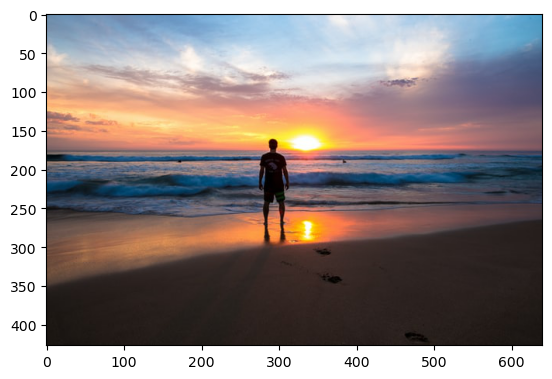



Cluster Size:  1


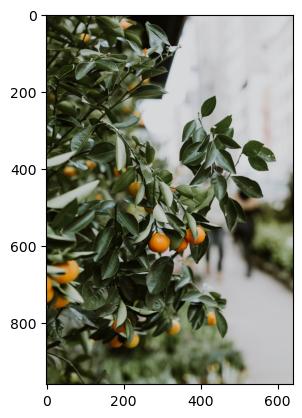



Cluster Size:  1


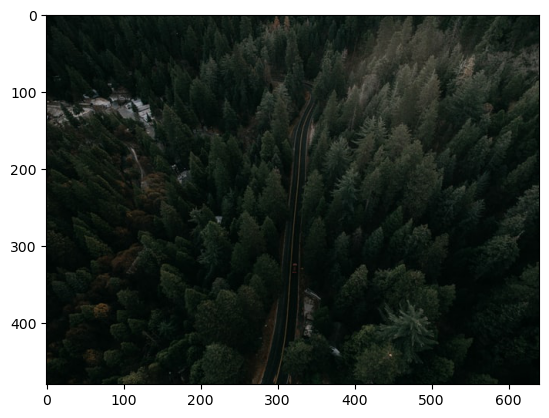



Cluster Size:  1


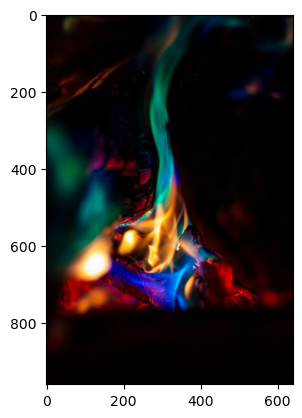



Cluster Size:  1


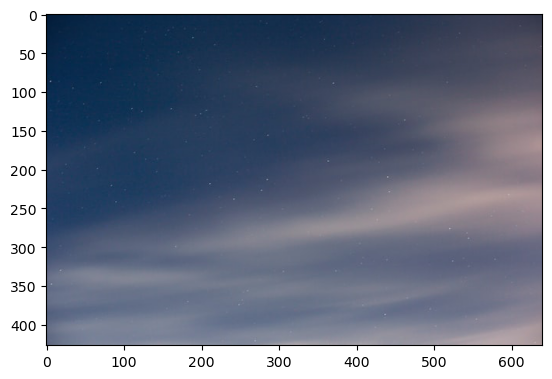



Cluster Size:  1


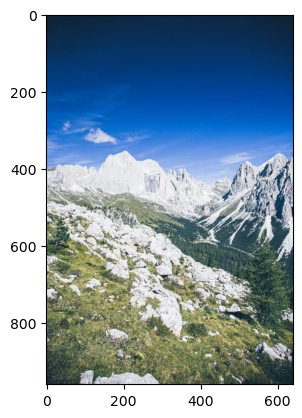



Cluster Size:  1


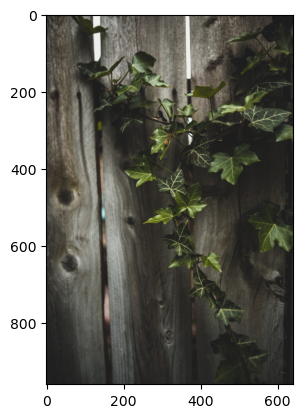



Cluster Size:  1


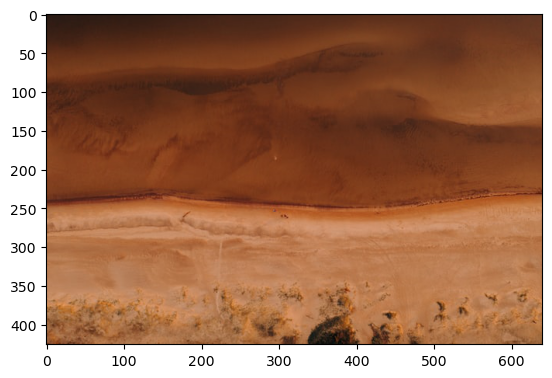



Cluster Size:  1


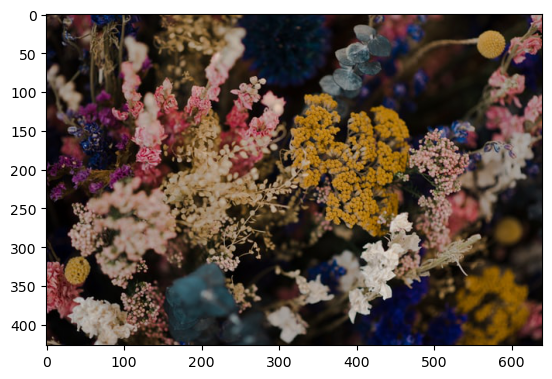



Cluster Size:  1


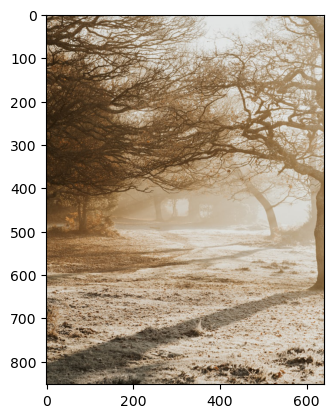

In [19]:
for cluster in unique_communities[0:10]:
  print("\n\nCluster Size: ", len(cluster))

  for idx in cluster[0:3]:
    img_path = img_names[idx]
    im = Image.open(img_path)
    plt.figure()
    plt.imshow(im)
    plt.show()